In [75]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
import os
from sklearn.calibration import IsotonicRegression

In [76]:
# Initialize WandB for tracking experiment
api_key = os.environ.get("WANDB_API_KEY")
wandb.login(key=api_key)
wandb.init(
    project="Neural Network",
    config={
        "architecture": "Neural Network",
        "dataset": "play-by-play-regular-season-2016-2019",
        "test_size": 0.2,
        "random_state": 42,
        "epochs": 50,
        "batch_size": 64,
        "learning_rate": 0.001,
    },
)

In [77]:
# Load dataset
play_by_play_path = "../../../data/dataframe_2016_to_2019.csv"
play_by_play = pd.read_csv(play_by_play_path)

# Filter for regular-season games and remove missing values
play_by_play = play_by_play.loc[play_by_play["gameType"] == "regular-season"].dropna()

# Remove non relevant features
X = play_by_play.drop(play_by_play.columns[[1, 2, 3, 5, 6, 14, 15, 16, 18, 19, 20, 21]], axis=1)
features_to_encode = ["previousEventType", "shotType"]

# Encode categorical features
def encode_and_bind(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    return pd.concat([df.drop(columns=feature), dummies], axis=1)

# Apply encoding on selected features
for feature in features_to_encode:
    X = encode_and_bind(X, feature)

y = play_by_play["isGoal"].values

# Split dataset into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing

In [78]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_validate_tensor = torch.tensor(X_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=wandb.config["batch_size"], shuffle=True)

### Model

In [79]:
# Define a simple neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize model, loss function, and optimizer
model = NeuralNet(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config["learning_rate"])


### Training

In [80]:
# Train the model
epochs = wandb.config["epochs"]
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Log epoch loss
    wandb.log({"epoch": epoch, "train_loss": epoch_loss / len(train_loader)})

### Evaluation

In [83]:
# Validate the model
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_validate_tensor)
    y_pred = (y_pred_probs > 0.5).float()
    
    # Compute accuracy
    accuracy = accuracy_score(y_validate_tensor.numpy(), y_pred.numpy())
    y_validate_np = y_validate_tensor.numpy().flatten()

# Log accuracy to WandB
wandb.log({"val_accuracy": accuracy})

# Save model
wandb_path = wandb.run.dir
model_path = f"{wandb_path}/Neural_Net.pth"
torch.save(model.state_dict(), model_path)
wandb.log_model(path=Path("./wandb"), name="Neural_Net")

wandb: Adding directory to artifact (.\wandb)... Done. 0.3s


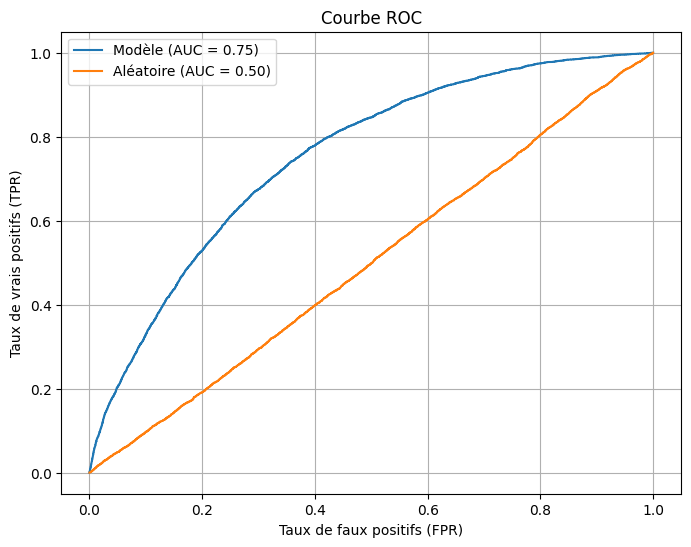

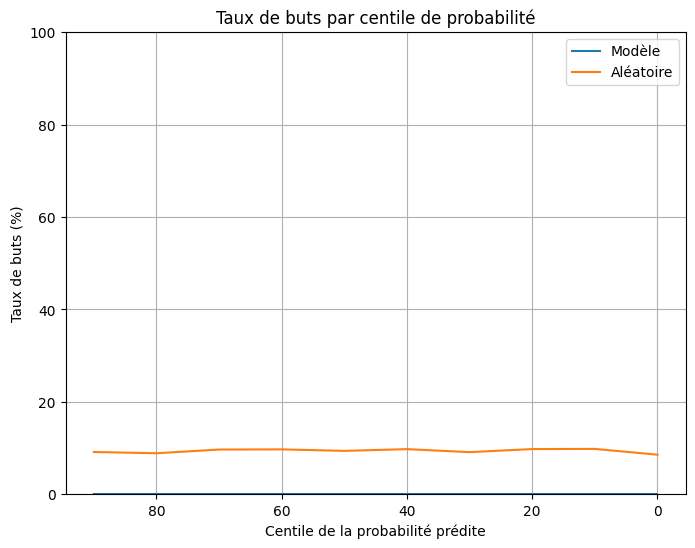

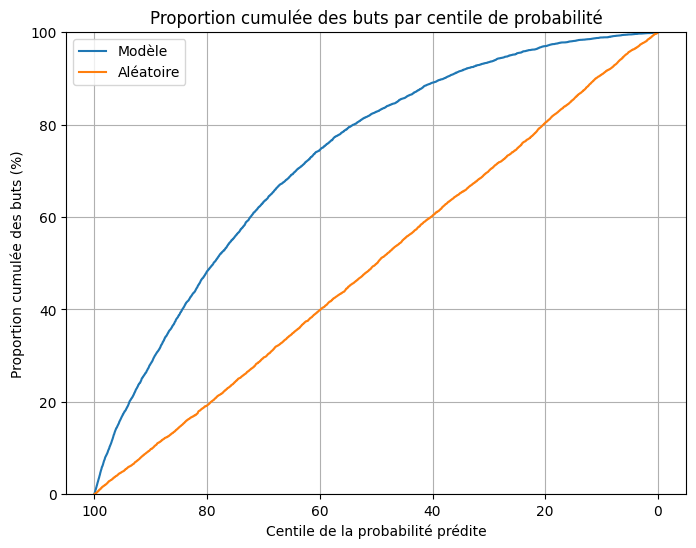

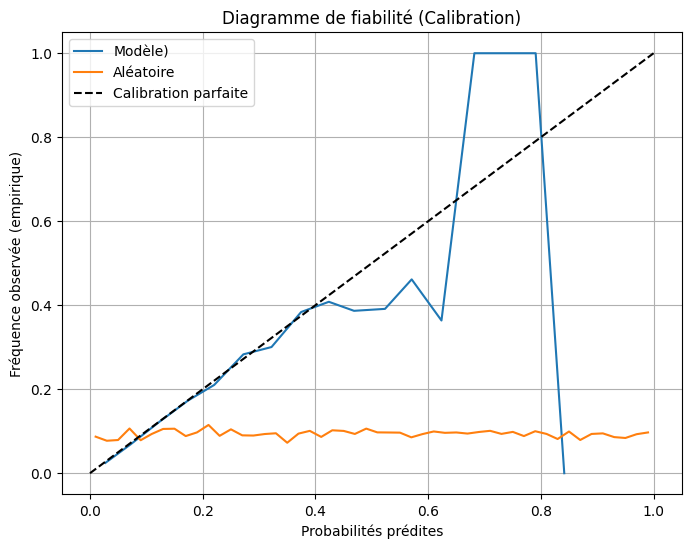

In [86]:
# Generate a random baseline (uniform probabilities)
np.random.seed(42)
prob_random = np.random.uniform(0, 1, len(y_validate_np))

# **1. ROC Curve and AUC**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_validate_np, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Add a baseline diagonal for random guessing
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid()
plt.show()

# **2. Goal Rate by Probability Percentile**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Sort probabilities and corresponding labels
    sorted_indices = np.argsort(prob)
    prob_sorted = np.array(prob[sorted_indices])
    y_sorted = np.array(y_validate_np[sorted_indices])

    # Compute goal rates by percentile
    percentiles = np.percentile(prob_sorted, np.arange(0, 101, 10))
    goal_rates = [
        y_sorted[(prob_sorted >= percentiles[i]) & (prob_sorted < percentiles[i + 1])].mean()
        if np.sum((prob_sorted >= percentiles[i]) & (prob_sorted < percentiles[i + 1])) > 0
        else 0
        for i in range(len(percentiles) - 1)
    ]
    plt.plot(np.arange(0, 100, 10), [rate * 100 for rate in goal_rates], label=name)

plt.xlabel("Centile de la probabilité prédite")
plt.ylabel("Taux de buts (%)")
plt.title("Taux de buts par centile de probabilité")
plt.ylim(0, 100)
plt.grid()
plt.legend()
plt.gca().invert_xaxis()  # Reverse the X-axis to go from 100% to 0%
plt.show()

# **3. Cumulative Goal Proportion**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Convert to NumPy array if it's a PyTorch tensor
    if isinstance(prob, torch.Tensor):
        prob = prob.numpy().flatten()

    # Sort probabilities in descending order
    sorted_indices = np.argsort(prob)[::-1]
    y_sorted = np.array(y_validate_np)[sorted_indices]

    # Compute cumulative goal proportion
    cumulative_goals = np.cumsum(y_sorted)
    total_goals = np.sum(y_sorted)
    cumulative_goal_proportion = cumulative_goals / total_goals

    # Percentiles
    centiles = np.linspace(100, 0, len(cumulative_goal_proportion))
    plt.plot(centiles, cumulative_goal_proportion * 100, label=name)

plt.xlabel("Centile de la probabilité prédite")
plt.ylabel("Proportion cumulée des buts (%)")
plt.title("Proportion cumulée des buts par centile de probabilité")
plt.ylim(0, 100)
plt.grid()
plt.legend()
plt.gca().invert_xaxis()
plt.show()

# **4. Calibration Curve**
# Generate Random Baseline
np.random.seed(42)
prob_random = np.random.uniform(0, 1, len(y_validate_np))

# Compute the Calibration Curves
fraction_of_positives_raw, mean_predicted_value_raw = calibration_curve(
    y_validate_np, y_pred_probs, n_bins=20, strategy="uniform"
)

# Generate Random Baseline
np.random.seed(42)
prob_random = np.random.uniform(0, 1, len(y_validate_np))
fraction_of_positives_random, mean_predicted_value_random = calibration_curve(
    y_validate_np, prob_random, n_bins=50, strategy="uniform"
)

plt.figure(figsize=(8, 6))
# Plot raw model calibration curve
plt.plot(
    mean_predicted_value_raw,
    fraction_of_positives_raw,
    "-",
    label=f"Modèle)"
)

# Plot random baseline calibration curve
plt.plot(
    mean_predicted_value_random,
    fraction_of_positives_random,
    "-",
    label="Aléatoire"
)

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], "k--", label="Calibration parfaite")

# Customize plot
plt.xlabel("Probabilités prédites")
plt.ylabel("Fréquence observée (empirique)")
plt.title("Diagramme de fiabilité (Calibration)")
plt.legend()
plt.grid()
plt.show()


In [85]:
# Log metric to WandB
wandb.log({"roc_auc": roc_auc})


# Finish WandB session
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
roc_auc,▁
train_loss,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
epoch,49
roc_auc,0.49962
train_loss,0.27125
val_accuracy,0.90601


source: chatgpt